# Machine Learning
In this notebook, we follow instructions [here](https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1) to try and predict the expected number of tweets in a day based on the previous day using Time Series Forecasting.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cs132_datefreq.csv')
df.columns = ['Date', 'Frequency']
pd.set_option('display.max_colwidth', None)
df.head().style.set_properties(**{'text-align': 'left'})

,Date,Frequency
0,2021-12-25,0
1,2021-12-26,1
2,2021-12-27,0
3,2021-12-28,1
4,2021-12-29,1


First, we take a look at our data.

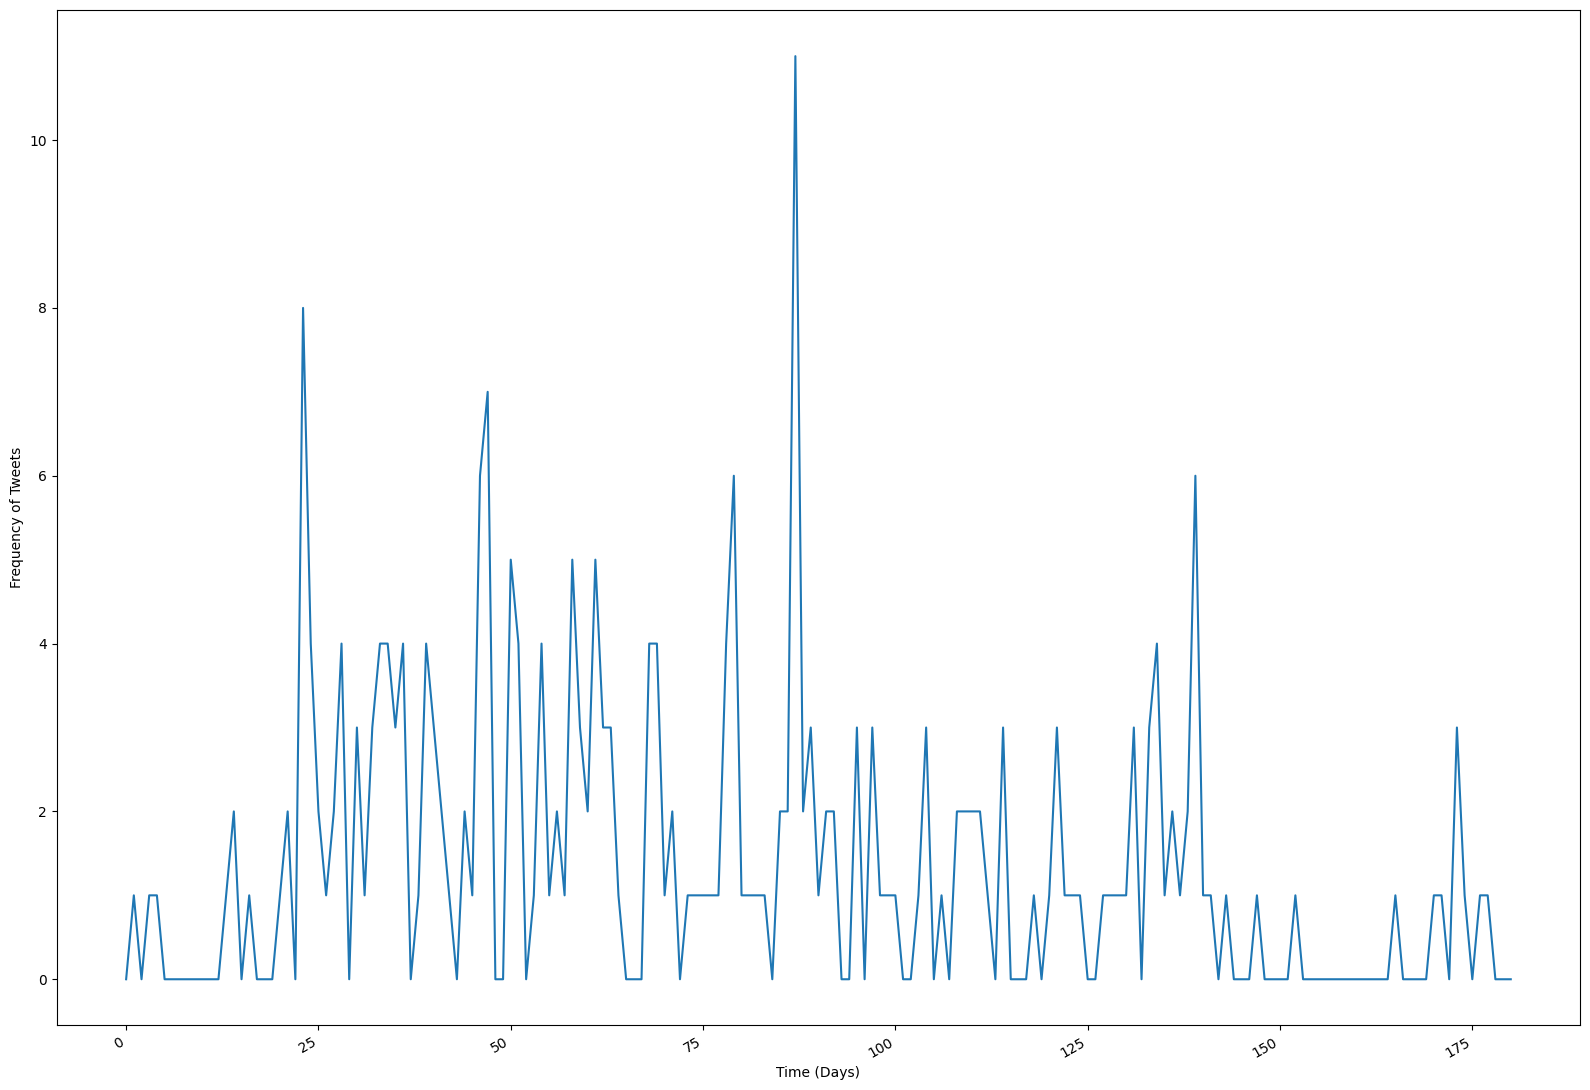

In [51]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(df['Frequency'])
ax.set_xlabel('Time (Days)')
ax.set_ylabel('Frequency of Tweets')
fig.autofmt_xdate()
plt.tight_layout()

We then create the actual value we're trying to predict as "Next Day Frequency".

In [52]:
df['Next Day Frequency'] = df['Frequency'].shift(-1)

Now, we split our data set into training and testing data. In this case, we try and use the data points prior to the start of the campaign period to predict the behavior of daily frequency throughout the time we cover.

In [53]:
train = df[:45]
test = df[45:]
test = test.drop(test.tail(1).index) # Drop last row
train.head().style.set_properties(**{'text-align': 'left'})

,Date,Frequency,Next Day Frequency
0,2021-12-25,0,1.000000
1,2021-12-26,1,0.000000
2,2021-12-27,0,1.000000
3,2021-12-28,1,1.000000
4,2021-12-29,1,0.000000


We create a baseline predictor that essentially just copies the frequency for ease of comparison later.

In [54]:
test = test.copy()
test['Baseline Prediction'] = test['Frequency']

test.head().style.set_properties(**{'text-align': 'left'})

,Date,Frequency,Next Day Frequency,Baseline Prediction
45,2022-02-08,1,6.000000,1
46,2022-02-09,6,7.000000,6
47,2022-02-10,7,0.000000,7
48,2022-02-11,0,0.000000,0
49,2022-02-12,0,5.000000,0


### Decision Tree

This model uses a simple decision tree with no cross-validation or hyperparameter tuning to perform regression on the training set and continuing on to predict throughout the test data set.

In [55]:
from sklearn.tree import DecisionTreeRegressor
X_train = train['Frequency'].values.reshape(-1,1)
y_train = train['Next Day Frequency'].values.reshape(-1,1)
X_test = test['Frequency'].values.reshape(-1,1)

# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_reg.fit(X=X_train, y=y_train)

# Make predictions
dt_pred = dt_reg.predict(X_test)

# Assign predictions to a new column in test
test['Decision Tree Prediction'] = dt_pred

test.head().style.set_properties(**{'text-align': 'left'})

,Date,Frequency,Next Day Frequency,Baseline Prediction,Decision Tree Prediction
45,2022-02-08,1,6.000000,1,1.400000
46,2022-02-09,6,7.000000,6,2.000000
47,2022-02-10,7,0.000000,7,4.000000
48,2022-02-11,0,0.000000,0,1.055556
49,2022-02-12,0,5.000000,0,1.055556


### Gradient Boosting

We now try a similar model frim `scikit-learn` so we can compare the results of the two.

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['Gradient Boosting Prediction'] = gbr_pred

test.head().style.set_properties(**{'text-align': 'left'})

,Date,Frequency,Next Day Frequency,Baseline Prediction,Decision Tree Prediction,Gradient Boosting Prediction
45,2022-02-08,1,6.000000,1,1.400000,1.400002
46,2022-02-09,6,7.000000,6,2.000000,1.999986
47,2022-02-10,7,0.000000,7,4.000000,3.999933
48,2022-02-11,0,0.000000,0,1.055556,1.055567
49,2022-02-12,0,5.000000,0,1.055556,1.055567


## Evaluation

We use the Mean Absolute Percentage Error to interpret how far/close our predictions are from the actual values and compare this across the models we've created.

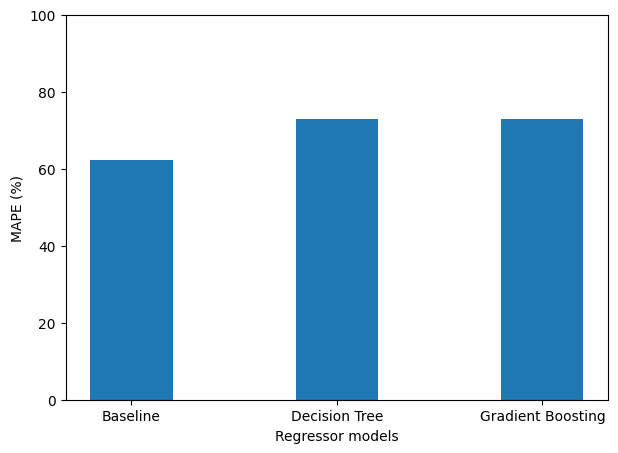

In [57]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100, 2) # +1 to avoid division by zero

baseline_mape = mape(test['Next Day Frequency'], test['Baseline Prediction'])
dt_mape = mape(test['Next Day Frequency'], test['Decision Tree Prediction'])
gbr_mape = mape(test['Next Day Frequency'], test['Gradient Boosting Prediction'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 100)

plt.show()

## Visualizing its behavior

Now that we have our predictions, we can look at the behavior of the models compared to the actual value.

In [58]:
df_combined = pd.concat([train, test], axis=0)
df_combined

,Date,Frequency,Next Day Frequency,Baseline Prediction,Decision Tree Prediction,Gradient Boosting Prediction
0,2021-12-25,0,1.0,NaN,NaN,NaN
1,2021-12-26,1,0.0,NaN,NaN,NaN
2,2021-12-27,0,1.0,NaN,NaN,NaN
3,2021-12-28,1,1.0,NaN,NaN,NaN
4,2021-12-29,1,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...
175,2022-06-18,0,1.0,0.0,1.055556,1.055567
176,2022-06-19,1,1.0,1.0,1.400000,1.400002
177,2022-06-20,1,0.0,1.0,1.400000,1.400002
178,2022-06-21,0,0.0,0.0,1.055556,1.055567


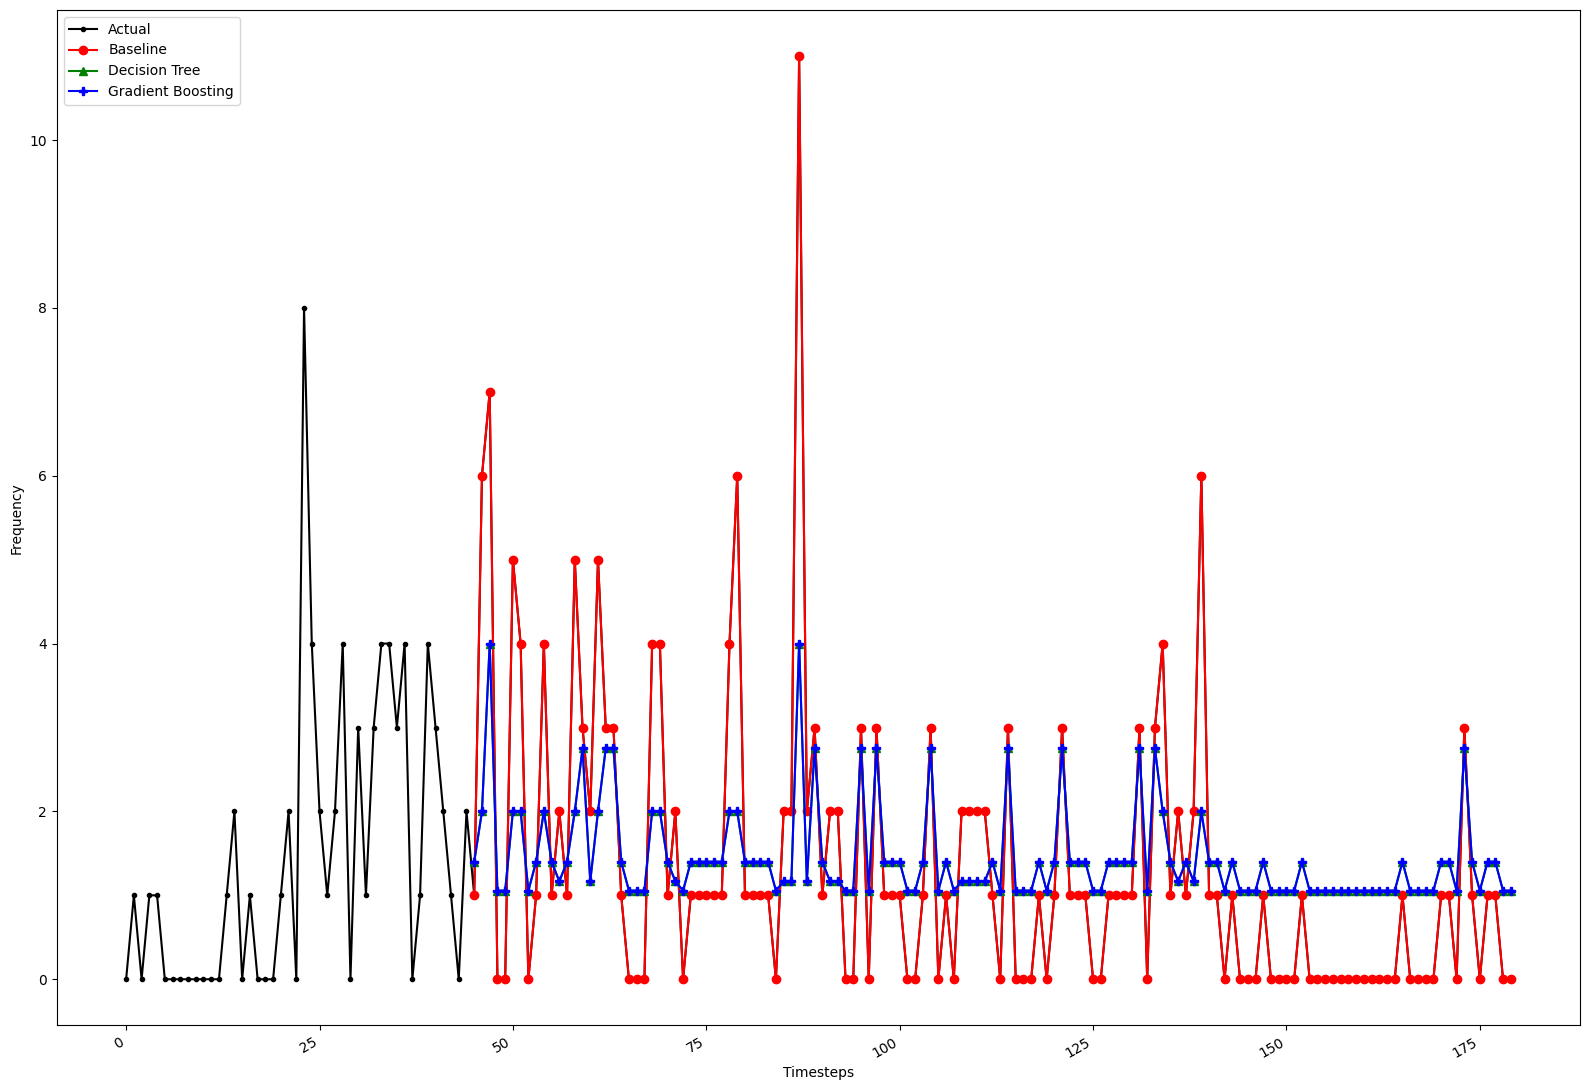

In [72]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(df_combined['Frequency'], marker='.', color='black', label='Actual')
ax.plot(df_combined['Baseline Prediction'], marker='o', color='red', label='Baseline')
ax.plot(df_combined['Decision Tree Prediction'], marker='^', color='green', label='Decision Tree')
ax.plot(df_combined['Gradient Boosting Prediction'], marker='P', color='blue', label='Gradient Boosting')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Frequency')

plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

Now we compare the behavior of the cumulative sums to help us look at the predicted cumulative frequency of tweets for each timestep.

In [64]:
df_combined['Sum'] = df_combined['Frequency'].cumsum()
df_combined['BP Sum'] = df_combined['Baseline Prediction'].cumsum()
df_combined['DT Sum'] = df_combined['Decision Tree Prediction'].cumsum()
df_combined['GB Sum'] = df_combined['Gradient Boosting Prediction'].cumsum()

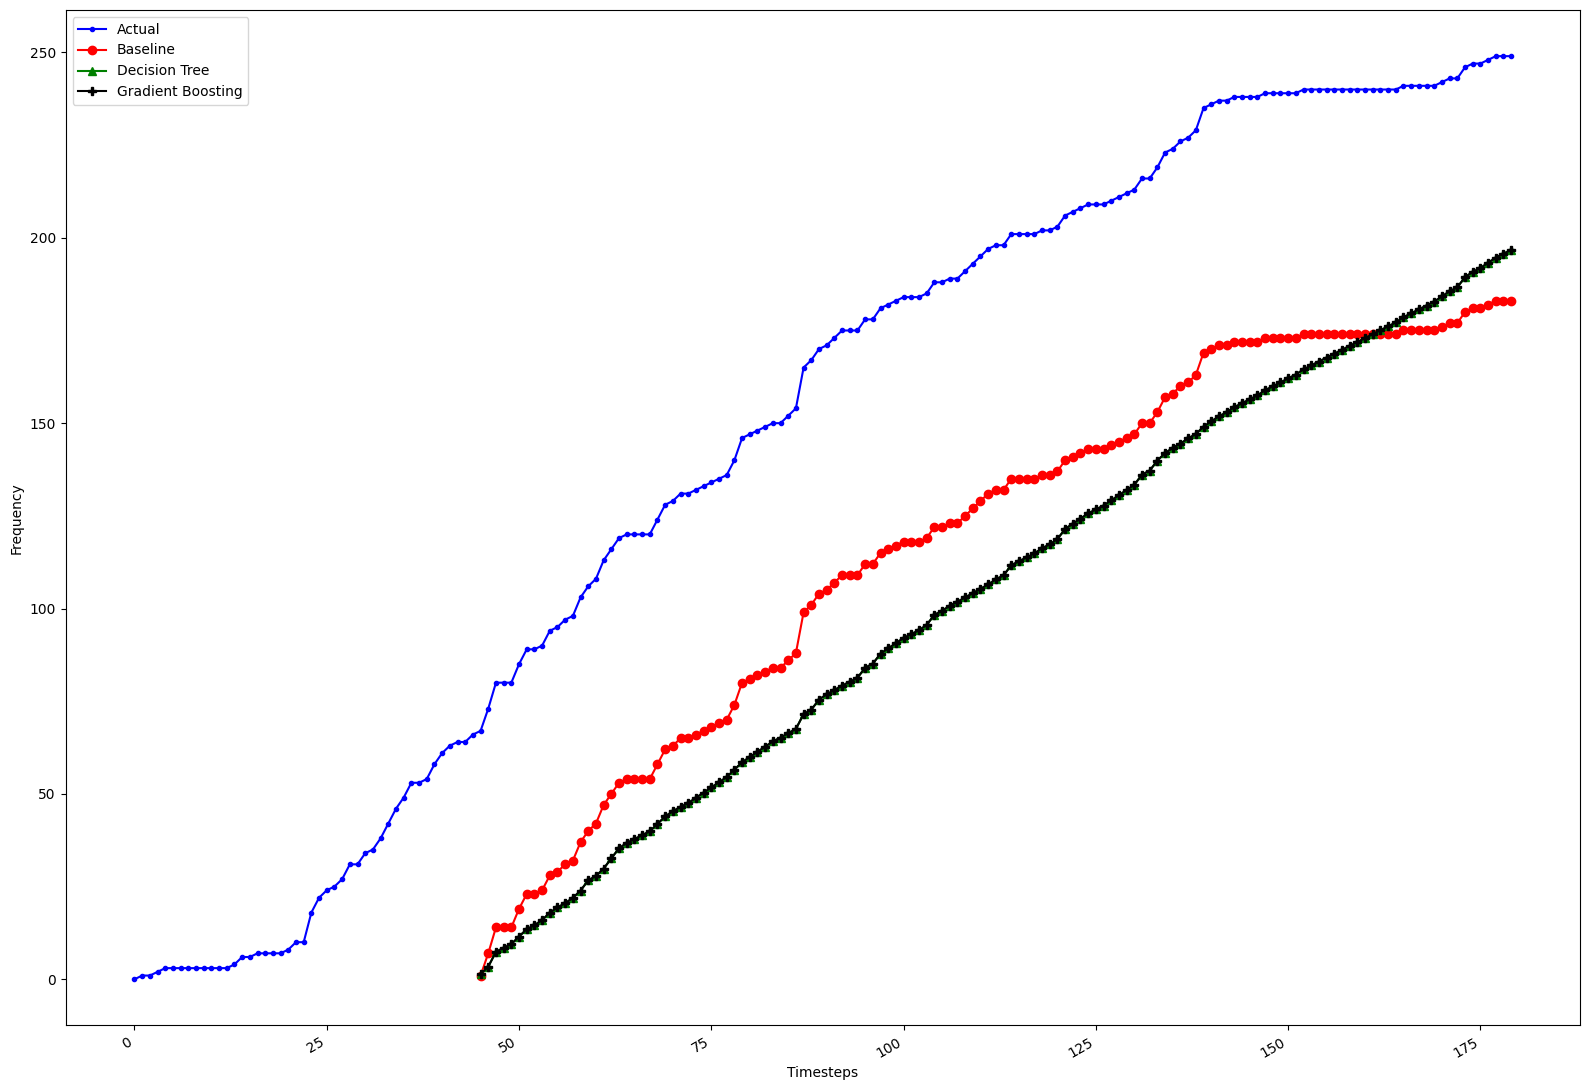

In [73]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(df_combined['Sum'], marker='.', color='blue', label='Actual')
ax.plot(df_combined['BP Sum'], marker='o', color='red', label='Baseline')
ax.plot(df_combined['DT Sum'], marker='^', color='green', label='Decision Tree')
ax.plot(df_combined['GB Sum'], marker='P', color='black', label='Gradient Boosting')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Frequency')

plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

As we can see, the actual value is much higher than any of our models' predictions but exploring other ways (different timesteps, training on cumulative sums, etc.) could lead to better performance. 